In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from tensorflow import keras

In [14]:
import os
results = np.load('/Users/sean/Desktop/college/intern/2D Wall/2D_Wall_Propped.npy')

In [15]:
E = 3e10 #Pa
nu = 0.2 # Poisson's ratio
G = E / (2 * (1 + nu)) # Shear modulus
rho = 2400 # kg/m^3

mesh_size = 0.05

width = 5   # m
depth = 8   # m
t = 0.1     # m
D =  E * t**3 / (12 * (1 - nu**2))

x_prop = width / 2

H_exposed = 5.0
D_embed = 3.0
H_total = H_exposed + D_embed
L = H_total
EI = 20e6  # Nm²
gamma = 18.0 * 1e3  # N/m³
Ka = 0.333
Kp_mobilised = 1.5  # Reduced passive pressure coefficient
Kp = 3.0
z_prop = 2.5       # Depth of prop from top [m]
zR_prop = 60e3   # N/m (resisting direction, into wall)
zR_prop *= width

tol = 1e-7

z_dense_lim1, z_dense_lim2 = 1.5, 3.5
x_dense_lim1, x_dense_lim2 = 1.5, 3.5

def is_in_dense_region(z, x):
    return (z_dense_lim1 <= z) & (z <= z_dense_lim2) & (x_dense_lim1 <= x) & (x <= x_dense_lim2)

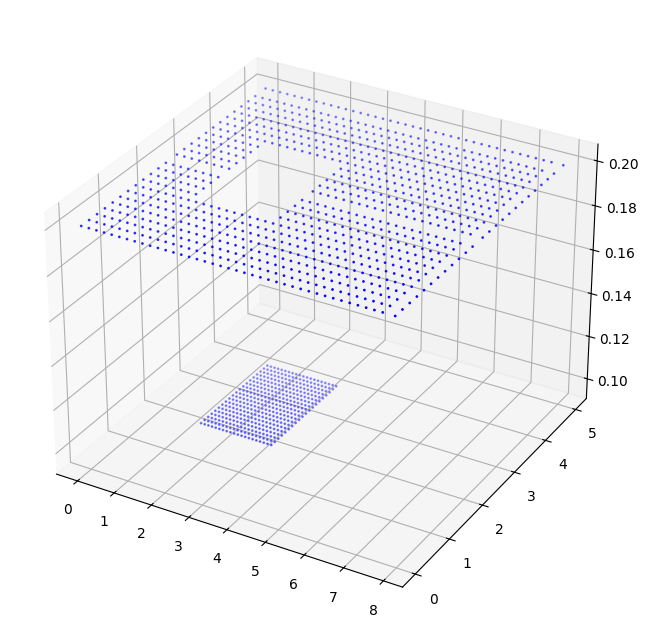

In [16]:
x_raw, z_raw, y_raw = np.split(results, 3, axis = -1)
x_raw_flatten, z_raw_flatten, y_raw_flatten = x_raw.flatten(), z_raw.flatten(), y_raw.flatten()

zdim_raw = z_raw.shape[0]
xdim_raw = x_raw.shape[1]
zdim = 40
xdim = int(zdim / depth * width)

z_sample_index = np.linspace(0, zdim_raw-1, zdim, dtype=int)
x_sample_index = np.linspace(0, xdim_raw-1, xdim, dtype=int)

z_sampled_raw = np.zeros_like(z_raw)
x_sampled_raw = np.zeros_like(x_raw)
y_sampled_raw = np.zeros_like(y_raw)

delta_z , delta_x = [], []

for z_in in range(x_raw.shape[0]):
    for x_in in range(x_raw.shape[1]):
        z, x, y = z_raw[z_in, x_in], x_raw[z_in, x_in], y_raw[z_in, x_in]
        if is_in_dense_region(z, x):
            z_sampled_raw[z_in, x_in] = z
            x_sampled_raw[z_in, x_in] = x
            y_sampled_raw[z_in, x_in] = y
            delta_z.append(depth / zdim_raw)
            delta_x.append(width / xdim_raw)
        else:
            if (not is_in_dense_region(z,x) and (z_in in z_sample_index) and (x_in in x_sample_index)):
                z_sampled_raw[z_in, x_in] = z
                x_sampled_raw[z_in, x_in] = x
                y_sampled_raw[z_in, x_in] = y
                delta_z.append(depth / zdim)
                delta_x.append(width / xdim)
            else:
                z_sampled_raw[z_in, x_in] = np.nan
                x_sampled_raw[z_in, x_in] = np.nan
                y_sampled_raw[z_in, x_in] = np.nan
                

z_sampled_flatten = z_sampled_raw.flatten()
x_sampled_flatten = x_sampled_raw.flatten()
y_sampled_flatten = y_sampled_raw.flatten()

z_flatten = z_sampled_flatten[~np.isnan(z_sampled_flatten)]
x_flatten = x_sampled_flatten[~np.isnan(x_sampled_flatten)]
y_flatten = y_sampled_flatten[~np.isnan(y_sampled_flatten)]

z_max = np.max(z_raw[:,0])
x_max = np.max(x_raw[0])
y_max = np.max(abs(y_raw))


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_flatten, x_flatten, delta_x, c='b', marker='o', s=1)

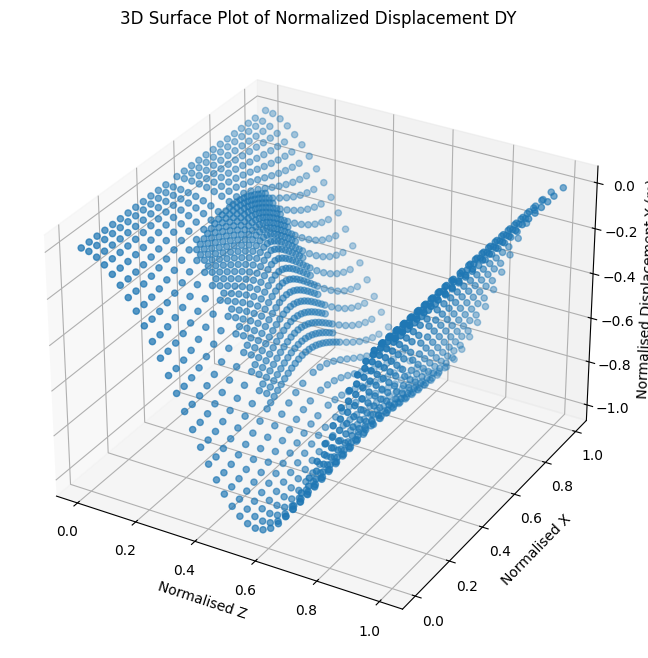

In [17]:
z_norm_flatten = z_flatten / z_max
x_norm_flatten = x_flatten / x_max
y_norm_flatten = y_flatten / y_max

z_norm_flatten_tf = tf.convert_to_tensor(z_norm_flatten, dtype=tf.float32)
x_norm_flatten_tf = tf.convert_to_tensor(x_norm_flatten, dtype=tf.float32)
y_norm_flatten_tf = tf.convert_to_tensor(y_norm_flatten, dtype=tf.float32)

delta_z = np.array(delta_z)
delta_x = np.array(delta_x)

results_norm_flatten = np.stack((z_norm_flatten, x_norm_flatten, y_norm_flatten, delta_z, delta_x), axis = -1)
results_norm_flatten_tf = tf.convert_to_tensor(results_norm_flatten, dtype=tf.float32)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.scatter(z_norm_flatten, x_norm_flatten, y_norm_flatten)
ax.set_xlabel('Normalised Z')
ax.set_ylabel('Normalised X')
ax.set_zlabel('Normalised Displacement Y (m)')
ax.set_title('3D Surface Plot of Normalized Displacement DY')

plt.show()

In [18]:
def q_soil_smooth(z, width=0.2):

    # Lines on either side of the break
    m1      =  Ka * gamma                                   # slope for z ≤ H
    m2      = (Ka - Kp_mobilised) * gamma                   # slope for z ≥ H
    c2      =  Kp_mobilised * gamma * H_exposed             # intercept so the
                                                            # two branches meet
    # Smooth switch 0→1 built from tanh
    w = 0.5 * (1 + np.tanh((z - H_exposed) / width))        # 0 left, 1 right

    return (1 - w) * (m1 * z) + w * (m2 * z + c2)
def gaussian_prop(z, x, force, xc = width/2, zc = z_prop, sigma = 1e-2):

    phi = force * tf.exp(-((x - xc)**2 + (z - zc)**2) / (2 * sigma**2))
    scale = 1 / (sigma * np.sqrt(2 * np.pi))
    
    return scale * phi

q_s = q_soil_smooth(z_norm_flatten)
q_max = max(q_s)
q_norm = q_s / q_max


In [19]:
model = keras.Sequential([
    keras.layers.Input(shape = (2,)),
    keras.layers.Dense(64, activation='swish'),
    keras.layers.Dense(64, activation='swish'),
    keras.layers.Dense(64, activation='swish'),
    keras.layers.Dense(64, activation='swish'),
    keras.layers.Dense(1)
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,737 (49.75 KB)

 Trainable params: 12,737 (49.75 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# --- 8. Initialize b1, c1, b2, c2
m_a = tf.Variable(0.5, dtype=tf.float32)
m_p = tf.Variable(1, dtype=tf.float32)
m_prop = tf.Variable(1, dtype=tf.float32)


# --- 9. Learning Rate Scheduler ---
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005, # Slightly lower initial LR
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


physics loss

In [21]:

def laplacian(inputs, func = model):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(inputs)
        with tf.GradientTape() as tape1:
            tape1.watch(inputs)
            f = func(inputs)
        grad = tape1.gradient(f, inputs)  # shape (N, D)
        dz, dx = tf.unstack(grad, axis = -1)
    
    
    dz2 = tf.unstack(tape2.gradient(dz, inputs), axis = -1)[0]
    dx2 = tf.unstack(tape2.gradient(dx, inputs), axis = -1)[1]
    
    return dz2 / z_max**2 + dx2 / x_max**2

def first_order_grad(inputs):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        f = model(inputs)
    dz, dx = tf.unstack(tape.gradient(f, inputs), axis = -1)
    dz = dz / z_max
    dx = dx / x_max
    g = tf.stack((dz, dx), axis = -1)
    return g

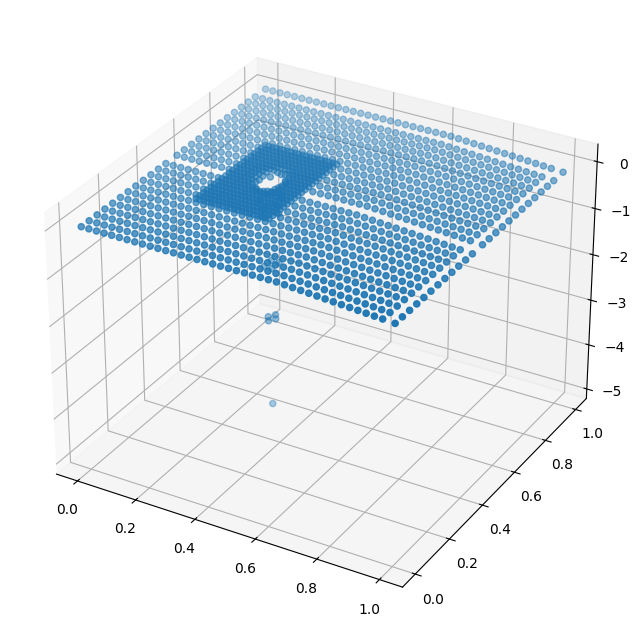

In [22]:
def gaussian_2D(z, x, force, deltaz, deltax, xc = x_prop, zc = z_prop, sigma = 0.1):

  dtype = z.dtype
  force, xc, zc, sigma = tf.cast(force, dtype), tf.cast(xc, dtype), tf.cast(zc, dtype), tf.cast(sigma, dtype)

  r2 = ((x - xc)**2 + (z - zc)**2) / (2 * sigma**2)
  phi = tf.exp(-r2)
  scale = force / (tf.reduce_sum(phi) * deltax * deltaz)
  d2 = (x - tf.cast(xc,dtype))**2 + (z - tf.cast(zc,dtype))**2

  return scale * phi

def piecewise_q(z_norm_flatten_tf, x_norm_flatten_tf, deltaz, deltax):  #input normalized
    z_phys = z_norm_flatten_tf * z_max
    
    q_s = tf.where(z_phys <= H_exposed, (m_a * gamma * Ka * z_phys), (m_a * gamma * Ka * z_phys - m_p*gamma*Kp*(z_phys-H_exposed)))
    q_prop = gaussian_2D(z_phys, x_norm_flatten_tf * x_max, zR_prop, deltaz, deltax)
    
    return q_s - q_prop
  
delta_z_tf = tf.convert_to_tensor(delta_z, dtype=tf.float32)
delta_x_tf = tf.convert_to_tensor(delta_x, dtype=tf.float32)  

q_test = piecewise_q(z_norm_flatten_tf, x_norm_flatten_tf, delta_z_tf, delta_x_tf)
fig.add_axes(ax)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_norm_flatten, x_norm_flatten, q_test)

In [23]:
N_DATA_ONLY_EPOCHS = 2000
N_BC_EPOCHS = 1000
N_PHYSICS_EPOCHS = 2000

@tf.function

def train_step(batch, epoch_val):
  z, x , y_true , deltaz, deltax= batch[:,0], batch[:,1], batch[:,2], batch[:,3], batch[:,4]
  with tf.GradientTape() as tape:
    zxstack = tf.stack((z, x), axis = -1)
    y_pred = model(zxstack)
    y_pred = tf.squeeze(y_pred, -1)  # Ensure y_pred is 1D
    data_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    y_at_z_boundaries = tf.where(z < (1 / zdim), y_pred, 0.0) + tf.where((1 - z) < (1 / zdim), y_pred, 0.0)
    bc_disp = tf.reduce_mean(tf.square(y_at_z_boundaries))
    
    gradz, gradx = tf.unstack(first_order_grad(zxstack), axis = -1)
    gradz_at_z_boundaries = tf.where(z < (1 / zdim), gradz, 0.0) + tf.where((1 - z) < (1 / zdim), gradz, 0.0)
    bc_z_loss = tf.reduce_mean(tf.square(gradz_at_z_boundaries))
    
    gradx_at_x_boundaries = tf.where(x < (1 / xdim), gradx, 0.0) + tf.where((1 - x) < (1 / xdim), gradx, 0.0)
    bc_x_loss = tf.reduce_sum(tf.square(gradx_at_x_boundaries)) 
    
    bc_loss = bc_disp + bc_z_loss + bc_x_loss
      
    biharmonic = laplacian(zxstack, laplacian)
    q_pred = piecewise_q(z, x, deltaz, deltax)
    physics_residual = tf.square(biharmonic * D * y_max / q_max - q_pred / q_max)
    physics_loss = tf.reduce_mean(physics_residual)

    if epoch_val < N_DATA_ONLY_EPOCHS:
        w_data, w_phys, w_bc = 1.0, 0.0, 0.2
    elif epoch_val < N_BC_EPOCHS:
        w_data, w_phys, w_bc = 0.2, 0.5, 0.1
    else:
        w_data, w_phys, w_bc = 1.0, 0.1, 0.2
        
    loss = w_data * data_loss + w_bc * bc_loss + w_phys * physics_loss

  variables = model.trainable_variables + [m_a, m_p]
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  del tape
  return loss, data_loss, bc_loss, physics_loss


In [24]:
def snapshot(model):
    snap = keras.models.clone_model(model)
    snap.build(model.input_shape)
    snap.set_weights(model.get_weights())
    return snap

In [25]:
# --- 0. batching parameters --------------------------------------------
BATCH_SIZE  = 1024
SHUFFLE_BUF = 10_000

model_phase1, model_phase2 = model, model

dataset = (tf.data.Dataset.from_tensor_slices(
              results_norm_flatten_tf)
           .shuffle(SHUFFLE_BUF, reshuffle_each_iteration=True)
           .batch(BATCH_SIZE)
           .prefetch(tf.data.AUTOTUNE))

# --- 1. history containers ---------------------------------------------
history        = {k: [] for k in ["loss", "data", "phys", "bc"]}
history_params = {"m_a": [], "m_p": []}

In [26]:
# --- 2. training loop ---------------------------------------------------
for epoch in range(5000):
    # We’ll keep the metrics from the *last* batch in this epoch
    for batch in dataset:
        loss, data_l, bc_l, phys_l = train_step(batch, tf.cast(epoch, tf.int32))

    # record those metrics (no division → no ZeroDivisionError)
    history["loss"].append(float(loss.numpy()))
    history["data"].append(float(data_l.numpy()))
    history["phys"].append(float(phys_l.numpy()))
    history["bc"].append(float(bc_l.numpy()))
    history_params["m_a"].append(m_a.numpy())
    history_params["m_p"].append(m_p.numpy())

    if epoch % 5 == 0:
        print(f"Epoch {epoch:3d} | "
              f"loss {loss.numpy():.3e} | "
              f"data {data_l.numpy():.3e} | "
              f"bc {bc_l.numpy():.3e} | "
              f"phys {phys_l.numpy():.3e}")
    
    if epoch == N_DATA_ONLY_EPOCHS - 1:
        model_phase1 = snapshot(model)
    if epoch == N_DATA_ONLY_EPOCHS + N_BC_EPOCHS - 1:
        model_phase2 = snapshot(model)


2025-08-08 20:59:51.672776: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-08 20:59:51.776831: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch   0 | loss 2.691e-01 | data 2.691e-01 | bc 2.580e-04 | phys 1.796e+04


2025-08-08 20:59:51.987733: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch   5 | loss 1.885e-01 | data 1.873e-01 | bc 6.195e-03 | phys 2.317e+04


2025-08-08 20:59:52.355685: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch  10 | loss 1.156e-01 | data 1.121e-01 | bc 1.716e-02 | phys 4.450e+04


2025-08-08 20:59:52.981724: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch  15 | loss 9.270e-02 | data 8.648e-02 | bc 3.111e-02 | phys 2.574e+04
Epoch  20 | loss 9.119e-02 | data 8.769e-02 | bc 1.749e-02 | phys 4.796e+04
Epoch  25 | loss 9.647e-02 | data 9.457e-02 | bc 9.470e-03 | phys 3.745e+04
Epoch  30 | loss 8.187e-02 | data 8.144e-02 | bc 2.157e-03 | phys 3.854e+04


2025-08-08 20:59:54.292643: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch  35 | loss 9.091e-02 | data 8.819e-02 | bc 1.363e-02 | phys 2.366e+04
Epoch  40 | loss 9.088e-02 | data 8.996e-02 | bc 4.619e-03 | phys 2.592e+04
Epoch  45 | loss 8.893e-02 | data 8.727e-02 | bc 8.283e-03 | phys 1.769e+04
Epoch  50 | loss 1.024e-01 | data 1.013e-01 | bc 5.306e-03 | phys 4.396e+04
Epoch  55 | loss 9.005e-02 | data 8.907e-02 | bc 4.896e-03 | phys 2.072e+04
Epoch  60 | loss 8.600e-02 | data 8.488e-02 | bc 5.613e-03 | phys 2.745e+04


2025-08-08 20:59:57.359631: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch  65 | loss 9.183e-02 | data 9.009e-02 | bc 8.744e-03 | phys 5.099e+04
Epoch  70 | loss 8.886e-02 | data 8.747e-02 | bc 6.938e-03 | phys 3.028e+04
Epoch  75 | loss 8.229e-02 | data 8.190e-02 | bc 1.939e-03 | phys 3.422e+04
Epoch  80 | loss 9.798e-02 | data 9.599e-02 | bc 9.942e-03 | phys 3.048e+04
Epoch  85 | loss 1.021e-01 | data 9.956e-02 | bc 1.275e-02 | phys 6.842e+04
Epoch  90 | loss 8.535e-02 | data 8.366e-02 | bc 8.451e-03 | phys 2.146e+04
Epoch  95 | loss 9.243e-02 | data 9.037e-02 | bc 1.031e-02 | phys 1.914e+04
Epoch 100 | loss 8.618e-02 | data 8.590e-02 | bc 1.374e-03 | phys 2.063e+04
Epoch 105 | loss 9.291e-02 | data 9.081e-02 | bc 1.051e-02 | phys 3.731e+04
Epoch 110 | loss 8.609e-02 | data 8.409e-02 | bc 9.990e-03 | phys 2.021e+04
Epoch 115 | loss 8.936e-02 | data 8.845e-02 | bc 4.517e-03 | phys 3.186e+04
Epoch 120 | loss 8.339e-02 | data 8.214e-02 | bc 6.213e-03 | phys 2.606e+04
Epoch 125 | loss 8.675e-02 | data 8.483e-02 | bc 9.567e-03 | phys 4.235e+04


2025-08-08 21:00:08.295020: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 130 | loss 9.185e-02 | data 9.076e-02 | bc 5.452e-03 | phys 2.225e+04
Epoch 135 | loss 8.698e-02 | data 8.495e-02 | bc 1.015e-02 | phys 5.817e+04
Epoch 140 | loss 7.677e-02 | data 7.470e-02 | bc 1.039e-02 | phys 2.921e+04
Epoch 145 | loss 7.971e-02 | data 7.835e-02 | bc 6.792e-03 | phys 2.117e+04
Epoch 150 | loss 7.547e-02 | data 7.466e-02 | bc 4.059e-03 | phys 2.048e+04
Epoch 155 | loss 6.859e-02 | data 6.731e-02 | bc 6.413e-03 | phys 4.002e+04
Epoch 160 | loss 6.861e-02 | data 6.699e-02 | bc 8.109e-03 | phys 4.155e+04
Epoch 165 | loss 5.122e-02 | data 5.058e-02 | bc 3.228e-03 | phys 3.090e+04
Epoch 170 | loss 4.971e-02 | data 4.818e-02 | bc 7.604e-03 | phys 3.962e+04
Epoch 175 | loss 3.837e-02 | data 3.763e-02 | bc 3.713e-03 | phys 1.939e+04
Epoch 180 | loss 3.901e-02 | data 3.598e-02 | bc 1.518e-02 | phys 4.299e+04
Epoch 185 | loss 3.671e-02 | data 3.522e-02 | bc 7.436e-03 | phys 5.178e+04
Epoch 190 | loss 3.408e-02 | data 3.168e-02 | bc 1.199e-02 | phys 2.366e+04
Epoch 195 | 

2025-08-08 21:00:46.104218: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 255 | loss 2.200e-02 | data 2.014e-02 | bc 9.303e-03 | phys 4.808e+04
Epoch 260 | loss 2.200e-02 | data 2.002e-02 | bc 9.897e-03 | phys 5.588e+04
Epoch 265 | loss 2.453e-02 | data 2.189e-02 | bc 1.320e-02 | phys 3.504e+04
Epoch 270 | loss 1.991e-02 | data 1.851e-02 | bc 6.972e-03 | phys 1.580e+04
Epoch 275 | loss 2.177e-02 | data 1.931e-02 | bc 1.227e-02 | phys 1.823e+04
Epoch 280 | loss 1.990e-02 | data 1.807e-02 | bc 9.178e-03 | phys 2.081e+04
Epoch 285 | loss 1.877e-02 | data 1.686e-02 | bc 9.564e-03 | phys 3.153e+04
Epoch 290 | loss 1.951e-02 | data 1.682e-02 | bc 1.343e-02 | phys 3.495e+04
Epoch 295 | loss 1.746e-02 | data 1.592e-02 | bc 7.676e-03 | phys 2.274e+04
Epoch 300 | loss 1.748e-02 | data 1.633e-02 | bc 5.759e-03 | phys 4.155e+04
Epoch 305 | loss 1.673e-02 | data 1.453e-02 | bc 1.097e-02 | phys 3.552e+04
Epoch 310 | loss 1.800e-02 | data 1.631e-02 | bc 8.451e-03 | phys 1.477e+04
Epoch 315 | loss 1.911e-02 | data 1.560e-02 | bc 1.757e-02 | phys 2.121e+04
Epoch 320 | 

2025-08-08 21:02:01.227829: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 515 | loss 1.015e-02 | data 8.030e-03 | bc 1.059e-02 | phys 2.212e+04
Epoch 520 | loss 9.825e-03 | data 7.541e-03 | bc 1.142e-02 | phys 3.123e+04
Epoch 525 | loss 8.547e-03 | data 7.219e-03 | bc 6.640e-03 | phys 2.216e+04
Epoch 530 | loss 7.589e-03 | data 6.347e-03 | bc 6.210e-03 | phys 2.597e+04
Epoch 535 | loss 8.024e-03 | data 7.184e-03 | bc 4.197e-03 | phys 3.362e+04
Epoch 540 | loss 8.509e-03 | data 6.975e-03 | bc 7.670e-03 | phys 3.712e+04
Epoch 545 | loss 8.432e-03 | data 6.677e-03 | bc 8.777e-03 | phys 3.960e+04
Epoch 550 | loss 8.614e-03 | data 7.292e-03 | bc 6.608e-03 | phys 5.784e+04
Epoch 555 | loss 9.152e-03 | data 6.912e-03 | bc 1.120e-02 | phys 2.592e+04
Epoch 560 | loss 7.784e-03 | data 6.485e-03 | bc 6.493e-03 | phys 2.108e+04
Epoch 565 | loss 6.864e-03 | data 6.068e-03 | bc 3.977e-03 | phys 2.745e+04
Epoch 570 | loss 7.931e-03 | data 7.165e-03 | bc 3.832e-03 | phys 2.183e+04
Epoch 575 | loss 7.709e-03 | data 6.689e-03 | bc 5.104e-03 | phys 2.263e+04
Epoch 580 | 

2025-08-08 21:04:29.923440: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1025 | loss 4.007e-03 | data 3.805e-03 | bc 1.008e-03 | phys 4.277e+04
Epoch 1030 | loss 3.745e-03 | data 3.556e-03 | bc 9.486e-04 | phys 4.617e+04
Epoch 1035 | loss 3.715e-03 | data 3.602e-03 | bc 5.678e-04 | phys 2.457e+04
Epoch 1040 | loss 3.698e-03 | data 3.568e-03 | bc 6.534e-04 | phys 2.185e+04
Epoch 1045 | loss 4.758e-03 | data 4.602e-03 | bc 7.809e-04 | phys 1.889e+04
Epoch 1050 | loss 4.143e-03 | data 4.029e-03 | bc 5.697e-04 | phys 4.076e+04
Epoch 1055 | loss 3.736e-03 | data 3.574e-03 | bc 8.086e-04 | phys 2.233e+04
Epoch 1060 | loss 3.725e-03 | data 3.591e-03 | bc 6.733e-04 | phys 3.537e+04
Epoch 1065 | loss 4.162e-03 | data 3.991e-03 | bc 8.528e-04 | phys 2.360e+04
Epoch 1070 | loss 3.597e-03 | data 3.482e-03 | bc 5.735e-04 | phys 1.988e+04
Epoch 1075 | loss 3.191e-03 | data 3.109e-03 | bc 4.121e-04 | phys 3.833e+04
Epoch 1080 | loss 3.440e-03 | data 3.252e-03 | bc 9.377e-04 | phys 3.947e+04
Epoch 1085 | loss 4.431e-03 | data 4.302e-03 | bc 6.439e-04 | phys 3.069e+04

2025-08-08 21:09:36.087241: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2050 | loss 1.648e+03 | data 8.800e-01 | bc 2.141e-01 | phys 1.647e+04
Epoch 2055 | loss 4.317e+03 | data 9.597e-01 | bc 3.076e-01 | phys 4.316e+04
Epoch 2060 | loss 2.270e+03 | data 9.108e-01 | bc 1.846e-01 | phys 2.269e+04
Epoch 2065 | loss 4.120e+03 | data 9.343e-01 | bc 2.134e-01 | phys 4.119e+04
Epoch 2070 | loss 2.312e+03 | data 8.343e-01 | bc 2.473e-01 | phys 2.311e+04
Epoch 2075 | loss 2.495e+03 | data 9.614e-01 | bc 3.045e-01 | phys 2.494e+04
Epoch 2080 | loss 4.227e+03 | data 8.432e-01 | bc 1.721e-01 | phys 4.226e+04
Epoch 2085 | loss 4.195e+03 | data 8.241e-01 | bc 1.168e-01 | phys 4.194e+04
Epoch 2090 | loss 2.971e+03 | data 8.383e-01 | bc 2.305e-01 | phys 2.970e+04
Epoch 2095 | loss 2.441e+03 | data 8.422e-01 | bc 1.428e-01 | phys 2.440e+04
Epoch 2100 | loss 2.512e+03 | data 8.436e-01 | bc 2.290e-01 | phys 2.511e+04
Epoch 2105 | loss 1.702e+03 | data 7.976e-01 | bc 1.502e-01 | phys 1.701e+04
Epoch 2110 | loss 1.941e+03 | data 9.125e-01 | bc 1.689e-01 | phys 1.940e+04

2025-08-08 21:19:44.382501: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4095 | loss 8.407e+02 | data 9.910e-01 | bc 7.459e-01 | phys 8.396e+03
Epoch 4100 | loss 1.341e+03 | data 8.182e-01 | bc 9.759e-01 | phys 1.340e+04
Epoch 4105 | loss 5.338e+03 | data 1.013e+00 | bc 7.173e-01 | phys 5.337e+04
Epoch 4110 | loss 1.789e+03 | data 9.153e-01 | bc 4.374e-01 | phys 1.788e+04
Epoch 4115 | loss 1.711e+03 | data 8.906e-01 | bc 9.770e-01 | phys 1.710e+04
Epoch 4120 | loss 4.717e+03 | data 9.513e-01 | bc 9.241e-01 | phys 4.716e+04
Epoch 4125 | loss 2.793e+03 | data 9.027e-01 | bc 9.271e-01 | phys 2.792e+04
Epoch 4130 | loss 2.413e+03 | data 7.889e-01 | bc 7.131e-01 | phys 2.412e+04
Epoch 4135 | loss 2.647e+03 | data 8.515e-01 | bc 7.237e-01 | phys 2.646e+04
Epoch 4140 | loss 6.200e+03 | data 8.586e-01 | bc 8.243e-01 | phys 6.199e+04
Epoch 4145 | loss 3.887e+03 | data 9.831e-01 | bc 8.146e-01 | phys 3.886e+04
Epoch 4150 | loss 1.644e+03 | data 8.498e-01 | bc 1.031e+00 | phys 1.643e+04
Epoch 4155 | loss 2.776e+03 | data 9.103e-01 | bc 6.456e-01 | phys 2.775e+04

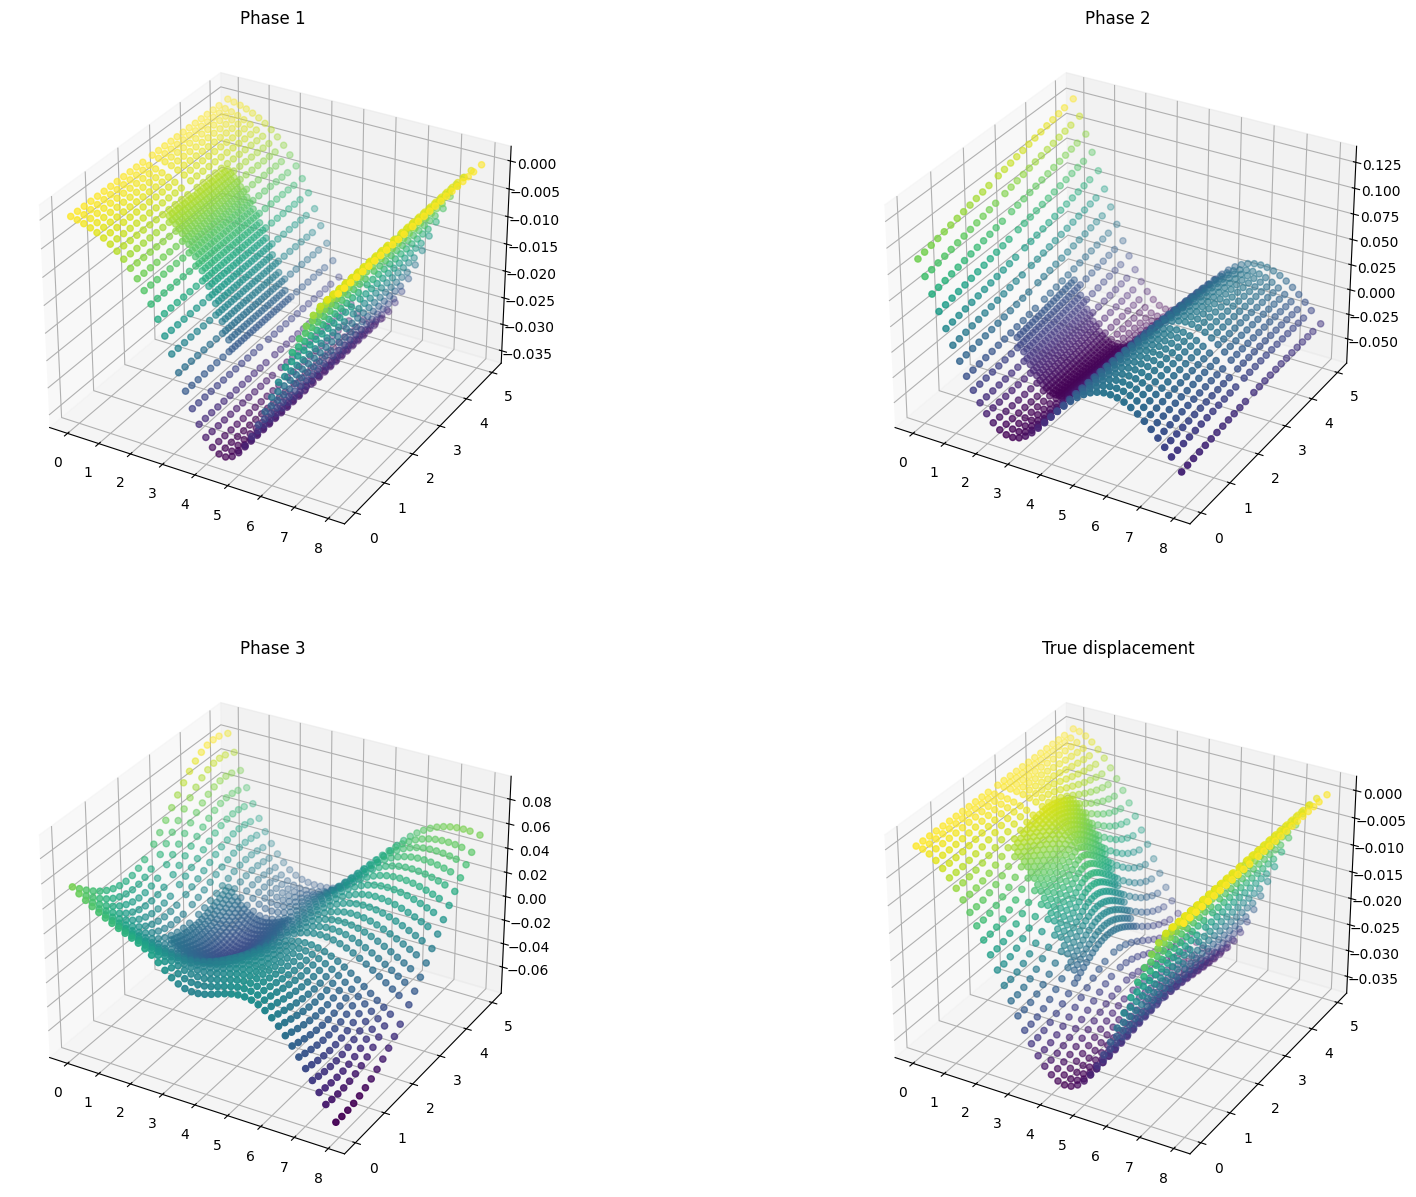

In [27]:

zxstack = tf.stack((z_norm_flatten_tf, x_norm_flatten_tf), axis = -1)

y_pred_norm1 = model_phase1(zxstack)
y_pred_norm1 = np.squeeze(y_pred_norm1, -1)
y_pred1 = y_pred_norm1 * y_max

y_pred_norm2 = model_phase2(zxstack)
y_pred_norm2 = np.squeeze(y_pred_norm2, -1)
y_pred2 = y_pred_norm2 * y_max

y_pred_norm3 = model(zxstack)
y_pred_norm3 = np.squeeze(y_pred_norm3, -1)
y_pred3 = y_pred_norm3 * y_max

fig = plt.figure(figsize=(20, 15))

ax1 = fig.add_subplot(221, projection = '3d')
ax1.scatter(z_flatten, x_flatten, y_pred1, c = y_pred1, cmap = 'viridis')
ax1.set_title('Phase 1')

ax2 = fig.add_subplot(222, projection='3d')
ax2.scatter(z_flatten, x_flatten, y_pred2, c = y_pred2, cmap='viridis')
ax2.set_title('Phase 2')

ax3 = fig.add_subplot(223, projection = '3d')
ax3.scatter(z_flatten, x_flatten, y_pred3, c = y_pred3, cmap = 'viridis')
ax3.set_title('Phase 3')

ax4 = fig.add_subplot(224, projection = '3d')
ax4.scatter(z_flatten, x_flatten, y_flatten, c = y_flatten, cmap = 'viridis')
ax4.set_title('True displacement')

plt.show()

NameError: name 'deltaz' is not defined

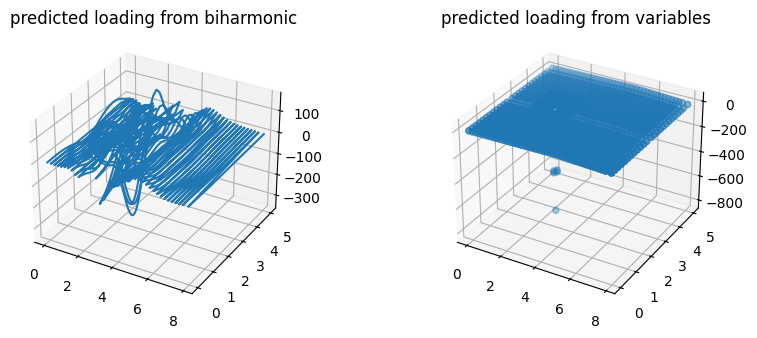

In [28]:
bih = laplacian(zxstack, laplacian)

cut = 0
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(221, projection = '3d')
ax1.plot(z_flatten[cut*xdim:], x_flatten[cut*xdim:], bih[cut*xdim:]* D * y_max / q_max)
ax1.set_title('predicted loading from biharmonic')

q_params = piecewise_q(z_norm_flatten_tf, x_norm_flatten_tf, delta_z_tf, delta_x_tf)
ax2 = fig.add_subplot(222, projection = '3d')
ax2.scatter(z_flatten[cut*xdim:], x_flatten[cut*xdim:], q_params[cut*xdim:]/q_max)
ax2.set_title('predicted loading from variables')

q_true = q_soil_smooth(z_flatten) - gaussian_2D(z_flatten, x_flatten, deltaz, deltax, zR_prop)
ax3 = fig.add_subplot(223, projection = '3d')
ax3.scatter(z_flatten[cut*xdim:], x_flatten[cut*xdim:], q_true[cut*xdim:]/q_max)
ax3.set_title('True loading')

gz, gx = tf.unstack(first_order_grad(zxstack), axis = -1)
ax4 = fig.add_subplot(224, projection = '3d')
ax4.scatter(z_flatten[cut*xdim:], x_flatten[cut*xdim:], gz[cut*xdim:])
ax4.set_title('gradz')
tf.print(m_a, m_p)

In [ ]:
epoch_plot = np.arange(len(history_params["m_a"]))

n = epoch

plt.figure(figsize=(10, 8))
plt.plot(epoch_plot[:n], history["data"][:n], label='data loss')
plt.plot(epoch_plot[:n], history["bc"][:n], label='bc loss')
plt.plot(epoch_plot[:n], history["phys"][:n], label='physics loss')
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(epoch_plot, history_params["m_a"], label='ma')
plt.plot(epoch_plot, history_params["m_p"], label='mp')
plt.legend()